# Demand Forecasting

In [1]:
# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings


warnings.filterwarnings('ignore')

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

### Loading the data

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

In [3]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [5]:
sample_sub = pd.read_csv('sample_submission.csv')

In [6]:
sample_sub

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52
...,...,...
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52


In [7]:
df = pd.concat([train, test], sort=False)

In [8]:
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


### Exploratory Data Analysis

In [9]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [10]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [11]:
# How many stores and items are there?

df[["store"]].nunique()

store    10
dtype: int64

In [12]:
df[["item"]].nunique()

item    50
dtype: int64

In [13]:
# How many unique items are in the store?

df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [14]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [15]:
# Summary Stats for each store and item

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [16]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


### FEATURE ENGINEERING

In [17]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype('int64')
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

In [18]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [19]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [20]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [21]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [22]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [23]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [24]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year               int64
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [25]:
########################
# Rolling Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [26]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [27]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [28]:
########################
# Exponentially Weighted Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [29]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [30]:
df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  \
0 2013-01-01      1     1   13.0 NaN      1             1            1   
1 2013-01-02      1     1   11.0 NaN      1             2            2   
2 2013-01-03      1     1   14.0 NaN      1             3            3   
3 2013-01-04      1  

In [31]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [32]:
########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)

## MODEL

In [33]:
########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [34]:
########################
# Time-Based Validation Sets
########################

train
test

# Training set until the beginning of 2017 (up to the end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

# Validation set for the first three months of 2017.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]
cols

['day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_ewm_alpha_095_lag_728',
 'sales_ewm_alpha_09_lag_91',
 'sales_ewm_alpha_09_lag_98',
 'sales_ewm_alpha_09_lag_105',
 'sales_ewm_alpha_09_lag_112',
 'sales_ewm_alpha_09_lag_180',
 'sales_ewm_alpha_09_lag_270',
 'sales_ewm_alpha_09_lag_365',
 'sales_ewm_alpha_09_lag_546',
 'sales_ewm_alpha_09_lag_728',
 'sales_ewm_alpha_08_lag_91',
 'sales_ewm_alpha_08_lag_98',
 'sales_ewm_alpha_08_lag_105',
 'sales_ewm_alpha_08_l

In [35]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [37]:
########################
# Time Series Modeling with LightGBM
########################

# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200, 
              'nthread': -1}

# Available metrics:
# mae: Mean Absolute Error (L1 loss)
# mse: Mean Squared Error (L2 loss)
# rmse: Root Mean Squared Error (Root L2 loss)
# mape: Mean Absolute Percentage Error

# num_leaves: Maximum number of leaves in a tree
# learning_rate: Shrinkage rate (also known as eta)
# feature_fraction: Fraction of features to be considered for each iteration (similar to random subspace method in Random Forest)
# max_depth: Maximum depth of the tree
# num_boost_round: Number of boosting iterations (usually at least 10000-15000 iterations are recommended)

# early_stopping_round: If the chosen metric does not improve for a certain number of rounds on the validation set,
# training is stopped to prevent overfitting and save time.
# nthread: Number of threads to use for parallelism (set to -1 to use all available CPU cores)


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],  
                  feval=lgbm_smape,
                  verbose_eval=100)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.102440 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513594	training's SMAPE: 17.5944	valid_1's l2: 0.0534399	valid_1's SMAPE: 17.5113
[200]	training's l2: 0.0352329	training's SMAPE: 14.5721	valid_1's l2: 0.0371165	valid_1's SMAPE: 14.9042
[300]	training's l2: 0.0324432	training's SMAPE: 14.017	valid_1's l2: 0.0341727	valid_1's SMAPE: 14.4339
[400]	training's l2: 0.0313863	training's SMAPE: 13.8065	valid_1's l2: 0.0333138	valid_1's SMAPE: 14.2813
[500]	training's l2: 0.0307212	training's SMAPE: 13.6729	valid_1's l2: 0.0326888	valid_1's SMAPE: 14.1488
[600]	training's l2: 0.030268	training's SMAPE: 13.5764	valid_1's l2: 0.0322353	valid_1's SMAPE: 14.0429
[700]	training's l2: 0.0299349	training's SMAPE: 13.5072	valid_1's l2: 0.0318984	valid_1's SMAPE: 13.9649
[800]	training's l2: 0.0296406	tr

[7600]	training's l2: 0.0267312	training's SMAPE: 12.8372	valid_1's l2: 0.0300757	valid_1's SMAPE: 13.5219
[7700]	training's l2: 0.026715	training's SMAPE: 12.8338	valid_1's l2: 0.0300749	valid_1's SMAPE: 13.5218
[7800]	training's l2: 0.0266992	training's SMAPE: 12.8306	valid_1's l2: 0.0300735	valid_1's SMAPE: 13.5216
[7900]	training's l2: 0.0266831	training's SMAPE: 12.8273	valid_1's l2: 0.0300717	valid_1's SMAPE: 13.5211
[8000]	training's l2: 0.0266663	training's SMAPE: 12.8239	valid_1's l2: 0.0300691	valid_1's SMAPE: 13.5205
[8100]	training's l2: 0.0266505	training's SMAPE: 12.8208	valid_1's l2: 0.0300661	valid_1's SMAPE: 13.5196
[8200]	training's l2: 0.0266342	training's SMAPE: 12.8175	valid_1's l2: 0.0300644	valid_1's SMAPE: 13.5191
[8300]	training's l2: 0.026619	training's SMAPE: 12.8143	valid_1's l2: 0.0300617	valid_1's SMAPE: 13.5186
[8400]	training's l2: 0.0266036	training's SMAPE: 12.8112	valid_1's l2: 0.0300602	valid_1's SMAPE: 13.5185
[8500]	training's l2: 0.0265878	trainin

In [38]:
########################
# Feature Importance
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

In [39]:
plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546   7340  53.937783
13                sales_lag_364   6027  13.124607
16          sales_roll_mean_365   5192   9.941327
60   sales_ewm_alpha_05_lag_365   1766   4.825674
18   sales_ewm_alpha_095_lag_91   1053   2.775026
..                          ...    ...        ...
118                     item_46     36   0.000265
4                is_month_start     22   0.000264
74                       item_2     48   0.000252
133                     month_4     16   0.000086
120                     item_48      2   0.000015

[142 rows x 3 columns]


,feature,split,gain
17,sales_roll_mean_546,7340,53.937783
13,sales_lag_364,6027,13.124607
16,sales_roll_mean_365,5192,9.941327
60,sales_ewm_alpha_05_lag_365,1766,4.825674
18,sales_ewm_alpha_095_lag_91,1053,2.775026
...,...,...,...
118,item_46,36,0.000265
4,is_month_start,22,0.000264
74,item_2,48,0.000252
133,month_4,16,0.000086


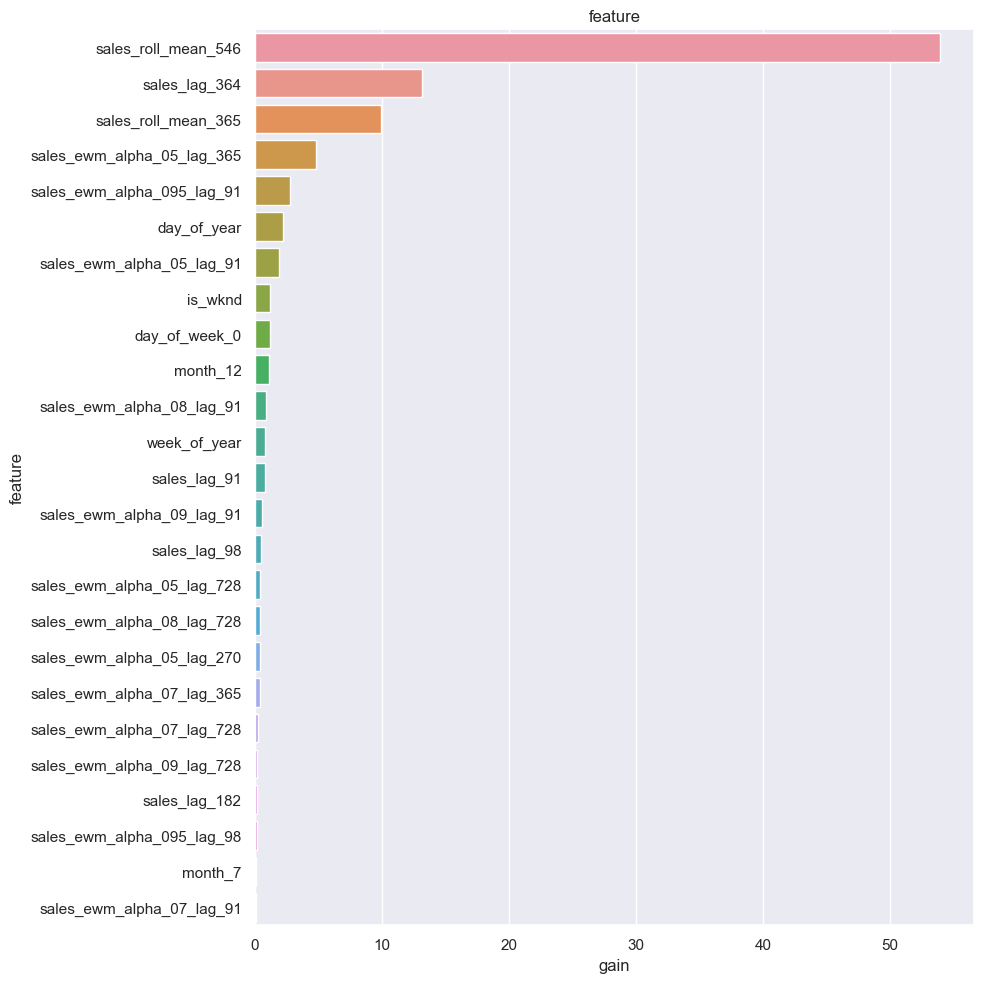

,feature,split,gain
17,sales_roll_mean_546,7340,53.937783
13,sales_lag_364,6027,13.124607
16,sales_roll_mean_365,5192,9.941327
60,sales_ewm_alpha_05_lag_365,1766,4.825674
18,sales_ewm_alpha_095_lag_91,1053,2.775026
...,...,...,...
118,item_46,36,0.000265
4,is_month_start,22,0.000264
74,item_2,48,0.000252
133,month_4,16,0.000086


In [40]:
plot_lgb_importances(model, num=30, plot=True)

In [41]:
feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                        feature  split       gain
17          sales_roll_mean_546   7340  53.937783
13                sales_lag_364   6027  13.124607
16          sales_roll_mean_365   5192   9.941327
60   sales_ewm_alpha_05_lag_365   1766   4.825674
18   sales_ewm_alpha_095_lag_91   1053   2.775026
..                          ...    ...        ...
118                     item_46     36   0.000265
4                is_month_start     22   0.000264
74                       item_2     48   0.000252
133                     month_4     16   0.000086
120                     item_48      2   0.000015

[142 rows x 3 columns]


142

In [43]:
########################
# Final Model
########################

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.275109 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [44]:
test_preds

array([2.58230807, 2.64004558, 2.71980166, ..., 4.38638663, 4.43623843,
       4.45741917])